In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import copy

#If using vscode do the following
# !pip install ipympl
# %matplotlib ipympl

#If using jupyter notebook do the following
%matplotlib notebook


### STEP 1: Set the parameters

In [2]:
np.random.seed(1)

numtrials = 500

numLGNCells = 7
numCortexCells = 3
numStim = 3
alpha = 0.25
wInh = 0.15
graphics = False
count = 0

lgn = np.zeros((numLGNCells, numLGNCells))
lgn_flag = np.zeros((numLGNCells, numLGNCells))
cortexV = np.zeros(numCortexCells)
cortexThr = 0.25 * np.ones(numCortexCells)
cortexPlast = np.zeros(numCortexCells)
cortexSET = np.ones(numCortexCells) * 0.35
cortexAVG = np.zeros(numCortexCells)
cortexDEV = np.zeros(numCortexCells)

historyV = np.zeros((numStim, numtrials))

### STEP 2: Run the simulation and save the data

In [3]:
w = .05 * np.random.rand(numCortexCells, numLGNCells, numLGNCells)

INPUT = np.array([

    [[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0]],

])

lgn_data = []
w_data = []
cortexV_data = []

for n in range(numtrials):
    for stim in range(numStim):
        lgn = INPUT[stim]

        cortexV = np.sum(lgn * w, axis=(1, 2))
        cortexV[cortexV > 1] = 1
        cortexV -= (np.sum(cortexV) - cortexV) * wInh

        cortexAVG = cortexAVG * 0.8 + cortexV * 0.2
        
        ######### PLASTICITY ###############
        
        cortexThr = cortexAVG ** 2 / cortexSET
        cortexPlast = cortexV * (cortexV - cortexThr)

        w = copy.deepcopy(w)
        w += alpha * lgn[None, :, :] * cortexPlast[:, None, None]
        w[w < 0] = 0
        
        ########## SAVE DATA FOR LATER PLOTTING ###################
        
        lgn_data.append(lgn)
        w_data.append(w)
        cortexV_data.append(cortexV)

        if graphics:
            update_plots(lgn, cortexV, w)
            count += 1
            
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(1.0)
            print(count)


    historyV[:, n] = cortexV

############ NOTES ON BCM ############
#   Real competition only starts late, because for a synapse to
#   decrease in strength, gain must be negative, for gain to be negative
#   modification threshold has to be above the voltage produced by the
#   nonprefered stimuli, since modif. threshold is direct function of
#   AVG, average must be pretty high meaning at least one stimulus is
#   producing a strong response.  Thus real competition only starts when
#   average is already close to SET.
    

### STEP 3: Visualise this with an animation

<IPython.core.display.Javascript object>


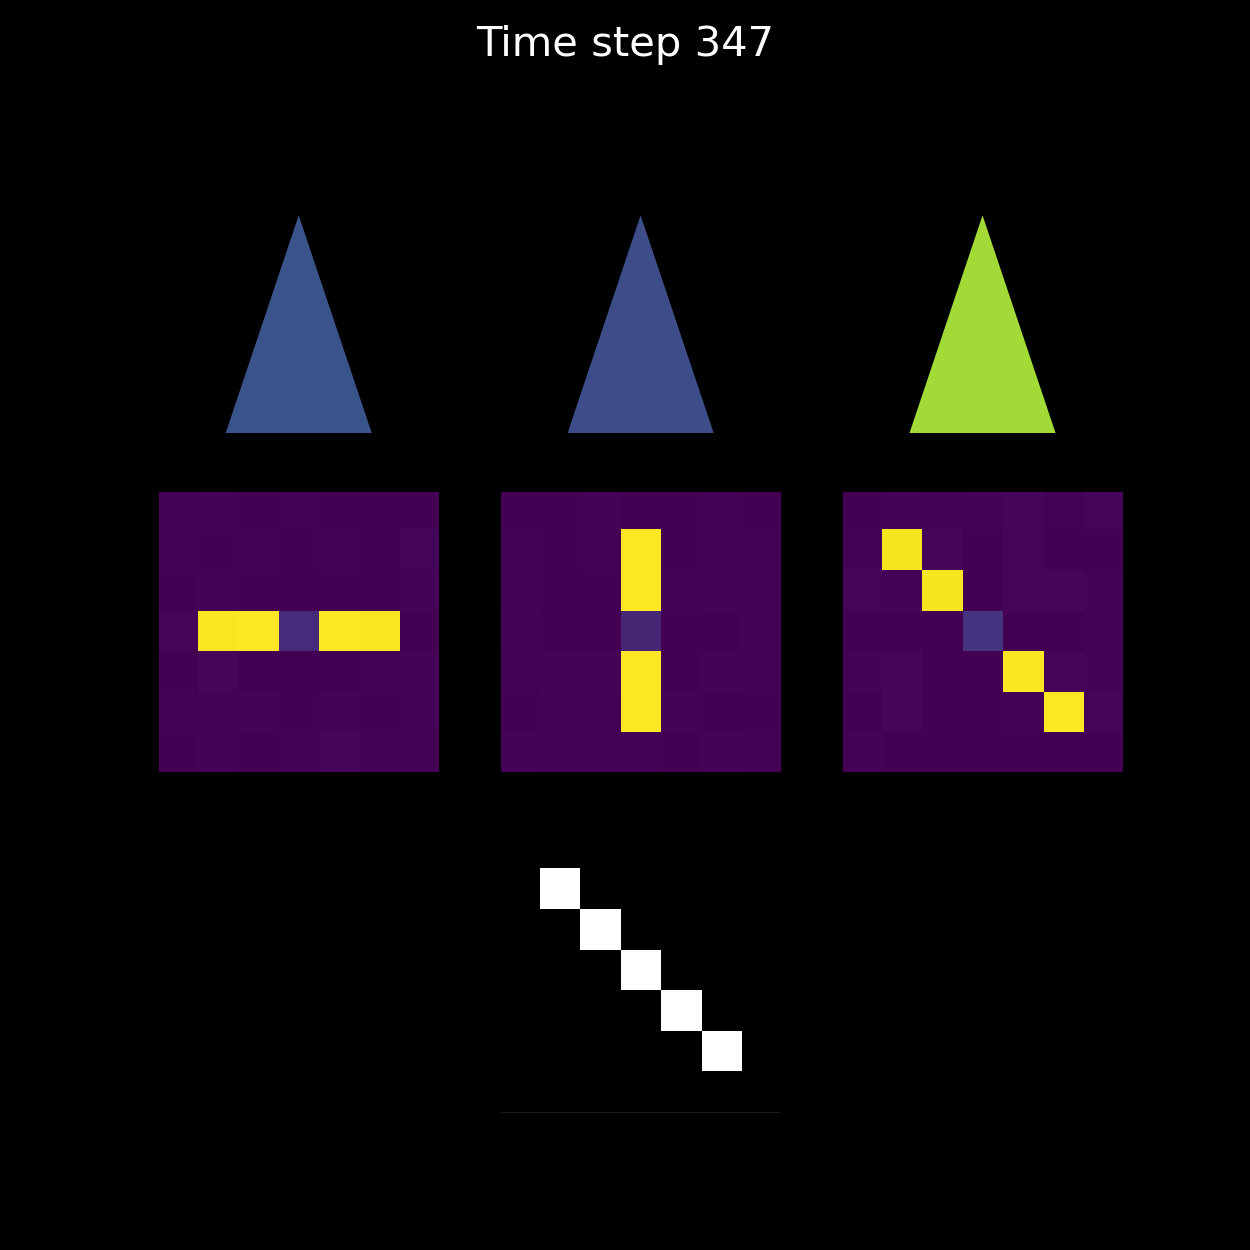

In [4]:
plt.rcParams['figure.facecolor'] = 'black'
cmap = plt.cm.viridis

fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(3, 3)
splgn = fig.add_subplot(gs[2, 1])

spw = []
spn = []
for i in range(numCortexCells):
    spw.append(fig.add_subplot(gs[1, i]))
    spn.append(fig.add_subplot(gs[0, i]))

splgn.axis('off')
triangle = np.array([[0.25, 0.5, 0.75, 0.25], [0, 0.75, 0, 0]])
for i in range(numCortexCells):
    spw[i].axis('off')
    spn[i].axis('off')
    spn[i].add_patch(plt.Polygon(triangle.T, color='blue'))
    spn[i].set_xlim([0, 1])
    spn[i].set_ylim([0, 1])

def animate(i):
    lgn = lgn_data[i]
    cortexV = cortexV_data[i]
    w = w_data[i]
    splgn.clear()
    splgn.imshow(lgn, cmap='gray')
    for j in range(numCortexCells):
        spw[j].clear()
        spw[j].imshow(w[j], cmap='viridis')
        spn[j].patches[0].set_color(cmap(cortexV[j]))
    fig.suptitle(f"Time step {i}",color='white')
    
anim = FuncAnimation(fig, animate, interval=100, frames=len(lgn_data))
plt.show()